<a href="https://colab.research.google.com/github/BenitoSupreme/OperationCrypto/blob/main/OperationCryptoVol1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries and link drive with csv file

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import requests
import time

from google.colab import drive
drive.mount('/content/drive')

#setting crypto_df as my dataframe
crypto_df=pd.read_csv("/content/drive/MyDrive/CryptoQuant/cryptomarkets.csv")[:2040]

Mounted at /content/drive


text here is a change

In [2]:
crypto_df.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32



#Preprocess Data

In [ ]:
#create a column 'optimal_spread' that gives a value of 1 if inbetween spread of 13-18
crypto_df['optimal_spread'] = 0

for i in range(len(crypto_df['spread'])):
  if crypto_df['spread'][i] > 13 and crypto_df['spread'][i] < 18:
    crypto_df['optimal_spread'][i] = 1
  else:
    crypto_df['optimal_spread'][i] = 0

#Train Dataset

In [4]:
X = crypto_df[['spread']].values # Features
y = crypto_df['open'].values # Target variable / label

In [5]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1) # 70% training and 30% test

##find the correct depth of decision tree

In [6]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='r2'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeRegressor(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [7]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train correlation', alpha=1)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('R Squared', fontsize=14)
    ax.set_ylim(0, 1.5)
    ax.set_xticks(depths)
    ax.legend()

In [8]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=1)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Cross Validation of r2 values', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

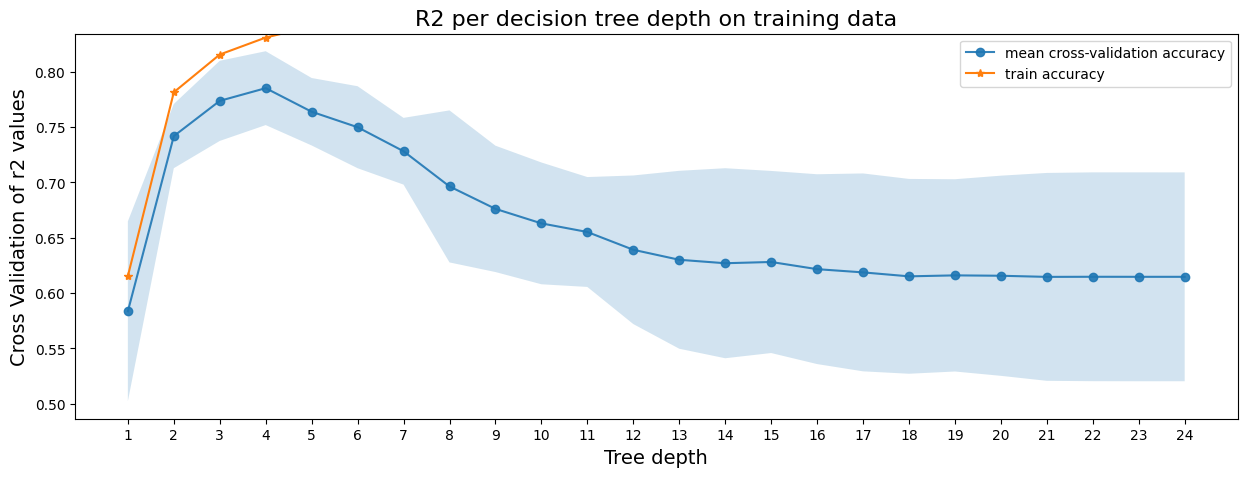

In [9]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'R2 per decision tree depth on training data')

In [10]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation r2 {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-4 tree achieves the best mean cross-validation r2 0.78518 +/- 1.66816% on training dataset


#Evaluate Real World Accuracy

In [11]:
# NOTE - are you classifying or creating a regression model - I think a regression which means you would do something like this ...

# Fitting Decision Tree Regression to the dataset
regressor = DecisionTreeRegressor()
regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

#Predict the response for test dataset
y_pred = regressor.predict(X_test.reshape(-1,1))

# Model Accuracy, how often is the classifier correct?
regressor.score(X_test.reshape(-1,1), y_test.reshape(-1,1))

0.6481161763386027

In [12]:
scoring_metric = 'r2'
cv_scores = cross_val_score(regressor, X, y, cv=5, scoring=scoring_metric)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Score: {cv_scores.mean()}')
print(f'Standard Deviation: {cv_scores.std()}')

Cross-Validation Scores: [-36.34736949 -14.90672523 -30.79593121  -3.19801609  -3.48285104]
Average Score: -17.7461786128215
Standard Deviation: 13.707329328125914


#Prediction

In [13]:
# Reshape the input data to a 2D array with a single feature (1 column)
X_test = np.array([5.0]).reshape(-1, 1)

# Perform prediction
prediction = regressor.predict(X_test)

# Print the prediction
print(prediction)

[106.21]
